# 9章
- データセット: CIFAR-10
    - 3x32x32
    - 10クラス
    - 50,000枚の訓練画像, 10,000枚の検証用画像 
- 機械学習モデル: CNN
    - 畳み込み
        - 位置の移動に無関係な特徴量を抽出
    - プーリング
        - Max Pooling
        - 物体の大きさによらない普遍的な特徴量を抽出
- 活性化関数: ReLU
- 損失関数: 交差エントロピー関数
- 最適化手法: SGD

- コードが長くなってきたので、関数にまとめる
    - fit （学習）
    - evaluate_history（学習ログ）
    - show_images_labels（予測結果表示）
    - torch_seed（乱数初期化）

# ライブラリ

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

# PyTorch関連ライブラリ
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets # データセット
import torchvision.transforms as transforms # 前処理
from torch.utils.data import DataLoader # データローダー
from tqdm.notebook import tqdm # プログレスバー

# warning表示off
import warnings
warnings.simplefilter('ignore')
# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14
# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)
# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True
# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

# GPUチェック

In [2]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 前処理の設定

In [3]:
# transform1: 一階テンソル化有り
transform1 = transforms.Compose([
    transforms.ToTensor(), # テンソル化
    transforms.Normalize(0.5, 0.5), # 正規化
    transforms.Lambda(lambda x: x.view(-1)), # 一階テンソル化
])

# transform2: 一階テンソル化無し
transform2 = transforms.Compose([
    transforms.ToTensor(), # テンソル化
    transforms.Normalize(0.5, 0.5), # 正規化
])

# データ準備

In [4]:
# ダウンロード先ディレクトリ名
data_root = './ignore_dir/data'

# 訓練データセット 1階テンソル版
train_set1 = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform1)

# 検証データセット 1階テンソル版
test_set1 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform1)

# 訓練データセット 3階テンソル版
train_set2 = datasets.CIFAR10(
    root =  data_root, train = True, 
    download = True, transform = transform2)

# 検証データセット 3階テンソル版
test_set2 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# データ件数の確認
print('訓練データ件数: ', len(train_set1))
print('テストデータ件数: ', len(test_set1))
print('訓練データ件数: ', len(train_set2))
print('テストデータ件数: ', len(test_set2))

訓練データ件数:  50000
テストデータ件数:  10000
訓練データ件数:  50000
テストデータ件数:  10000


In [6]:
# テンソルの次元確認
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]
print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


# データローダー
- 訓練用のデータローダーはシャッフル有り
- 検証用のデータローダーはシャッフル無し

In [7]:
# ミニバッチのサイズ指定
batch_size = 100
# 訓練用データローダー
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True) # 訓練用なので、シャッフルをかける
# 検証用データローダー
test_loader1 = DataLoader(test_set1,  batch_size=batch_size, shuffle=False) # 検証時にシャッフルは不要
# 訓練用データローダー
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True) # 訓練用なので、シャッフルをかける
# 検証用データローダー
test_loader2 = DataLoader(test_set2,  batch_size=batch_size, shuffle=False)  # 検証時にシャッフルは不要

In [8]:
# 何組のデータが取得できるか
print(len(train_loader2))
# DataLoaderから最初の1セットを取得する
for images, labels in train_loader1:
    break
print(images.shape)
print(labels.shape)

500
torch.Size([100, 3072])
torch.Size([100])


In [9]:
# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break

# train_loader2から1セット取得
for images2, labels2 in train_loader2:
    break

# それぞれのshape確認
print(images1.shape)
print(images2.shape)

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


# イメージ確認

In [10]:
# イメージとラベル表示のための関数
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

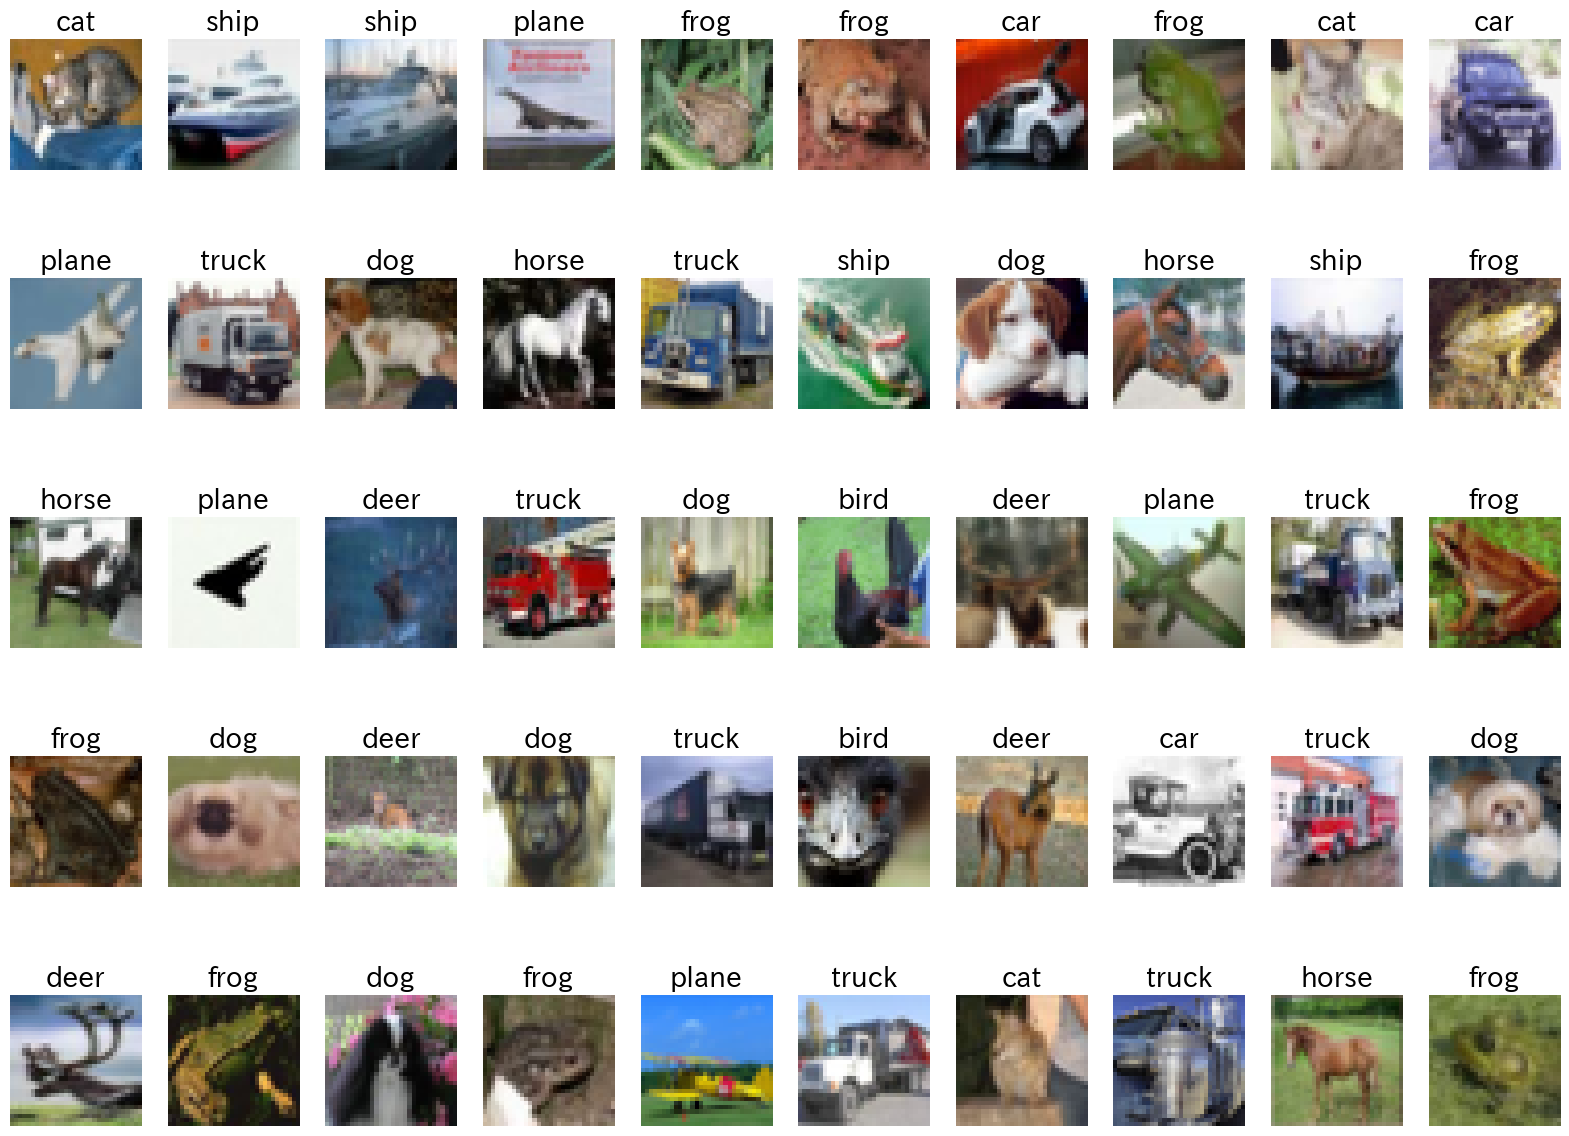

In [11]:
# 正解ラベル定義
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 検証データ最初の50個の表示
show_images_labels(test_loader2, classes, None, None)

# モデルの定義

In [12]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3    

# パラメータ設定＆モデル概要確認

In [13]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

# 乱数初期化
torch_seed()

In [14]:
# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(classes)

# 隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_hidden: {n_hidden} n_output: {n_output}')

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

n_hidden: 128 n_output: 10


In [15]:
# 学習率
lr = 0.01

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()


# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history2 = np.zeros((0,5))

In [16]:
# モデルの概要表示
print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [17]:
# モデルのサマリー表示
summary(net,(100,3,32,32),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 32, 14, 14]         10,144
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Flatten: 1-6                           [100, 6272]               --
├─Sequential: 1-7                        [100, 10]                 804,234
Total params: 823,626
Trainable params: 823,626
Non-trainable params: 0
Total mult-adds (M): 886.11
Input size (MB): 1.23
Forward/backward pass size (MB): 43.22
Params size (MB): 3.26
Estimated Total Size (MB): 47.71

# 計算グラフ可視化?

# 訓練

### fit学習用

In [18]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        # 1エポックあたりの正解数(精度計算用)
        n_train_acc, n_val_acc = 0, 0
        # 1エポックあたりの累積損失(平均化前)
        train_loss, val_loss = 0, 0
        # 1エポックあたりのデータ累積件数
        n_train, n_test = 0, 0

        #訓練フェーズ
        net.train()

        for inputs, labels in tqdm(train_loader):
            # 1バッチあたりのデータ件数
            train_batch_size = len(labels)
            # 1エポックあたりのデータ累積件数
            n_train += train_batch_size
    
            # GPUヘ転送
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測ラベル導出
            predicted = torch.max(outputs, 1)[1]

            # 平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            train_loss += loss.item() * train_batch_size 
            n_train_acc += (predicted == labels).sum().item() 

        #予測フェーズ
        net.eval()

        for inputs_test, labels_test in test_loader:
            # 1バッチあたりのデータ件数
            test_batch_size = len(labels_test)
            # 1エポックあたりのデータ累積件数
            n_test += test_batch_size

            # GPUヘ転送
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            # 予測計算
            outputs_test = net(inputs_test)

            # 損失計算
            loss_test = criterion(outputs_test, labels_test)
 
            # 予測ラベル導出
            predicted_test = torch.max(outputs_test, 1)[1]

            #  平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            val_loss +=  loss_test.item() * test_batch_size
            n_val_acc +=  (predicted_test == labels_test).sum().item()

        # 精度計算
        train_acc = n_train_acc / n_train
        val_acc = n_val_acc / n_test
        # 損失計算
        avg_train_loss = train_loss / n_train
        avg_val_loss = val_loss / n_test
        # 結果表示
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {val_acc:.5f}')
        # 記録
        item = np.array([epoch+1, avg_train_loss, train_acc, avg_val_loss, val_acc])
        history = np.vstack((history, item))
    return history

### eval_history 学習ログ解析用

In [19]:
# 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

In [20]:
# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 2.08382 acc: 0.25786 val_loss: 1.86626, val_acc: 0.35040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.78060 acc: 0.37612 val_loss: 1.67062, val_acc: 0.41580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.60925 acc: 0.43236 val_loss: 1.53155, val_acc: 0.45030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.48468 acc: 0.47272 val_loss: 1.42050, val_acc: 0.49360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.40529 acc: 0.49972 val_loss: 1.38492, val_acc: 0.50850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.34827 acc: 0.52258 val_loss: 1.32968, val_acc: 0.52510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.29528 acc: 0.54002 val_loss: 1.28135, val_acc: 0.54130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.24729 acc: 0.55918 val_loss: 1.27534, val_acc: 0.54710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.19866 acc: 0.57698 val_loss: 1.23286, val_acc: 0.56550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.15485 acc: 0.59286 val_loss: 1.17775, val_acc: 0.58340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.11074 acc: 0.60970 val_loss: 1.15290, val_acc: 0.59220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.07280 acc: 0.62516 val_loss: 1.13985, val_acc: 0.60040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.03468 acc: 0.63752 val_loss: 1.13157, val_acc: 0.60080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.99236 acc: 0.65342 val_loss: 1.08827, val_acc: 0.61760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.95642 acc: 0.66610 val_loss: 1.07549, val_acc: 0.62130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.91843 acc: 0.68022 val_loss: 1.04683, val_acc: 0.63680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.87844 acc: 0.69276 val_loss: 1.03042, val_acc: 0.63360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.84361 acc: 0.70606 val_loss: 1.02591, val_acc: 0.64210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.80365 acc: 0.71970 val_loss: 1.00974, val_acc: 0.64940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.76825 acc: 0.73372 val_loss: 1.01214, val_acc: 0.64330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.73465 acc: 0.74462 val_loss: 0.99653, val_acc: 0.65680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.70083 acc: 0.75644 val_loss: 1.00785, val_acc: 0.65600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.66671 acc: 0.77096 val_loss: 1.01189, val_acc: 0.65370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.63235 acc: 0.78160 val_loss: 0.98408, val_acc: 0.66980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.59789 acc: 0.79462 val_loss: 1.00250, val_acc: 0.66530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.56334 acc: 0.80616 val_loss: 1.02240, val_acc: 0.65640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.53128 acc: 0.81790 val_loss: 1.01810, val_acc: 0.66720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.49999 acc: 0.82948 val_loss: 1.01891, val_acc: 0.66900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.46665 acc: 0.84028 val_loss: 1.04019, val_acc: 0.66960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.43242 acc: 0.85448 val_loss: 1.10122, val_acc: 0.66040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.40322 acc: 0.86396 val_loss: 1.10804, val_acc: 0.66300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.37142 acc: 0.87558 val_loss: 1.19116, val_acc: 0.65240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.34258 acc: 0.88716 val_loss: 1.20327, val_acc: 0.65300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.31350 acc: 0.89732 val_loss: 1.23042, val_acc: 0.65530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.28788 acc: 0.90566 val_loss: 1.30168, val_acc: 0.64370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.25979 acc: 0.91694 val_loss: 1.28416, val_acc: 0.65710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.23153 acc: 0.92822 val_loss: 1.29389, val_acc: 0.66690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.20377 acc: 0.93770 val_loss: 1.32996, val_acc: 0.65980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.18330 acc: 0.94546 val_loss: 1.37732, val_acc: 0.66230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.16159 acc: 0.95286 val_loss: 1.42449, val_acc: 0.65820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.14395 acc: 0.95876 val_loss: 1.49804, val_acc: 0.65690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.12636 acc: 0.96516 val_loss: 1.53047, val_acc: 0.65380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.09876 acc: 0.97764 val_loss: 1.57996, val_acc: 0.65230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.08117 acc: 0.98298 val_loss: 1.64464, val_acc: 0.65400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.06959 acc: 0.98796 val_loss: 1.67472, val_acc: 0.65190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.09724 acc: 0.98160 val_loss: 1.65378, val_acc: 0.65470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.04975 acc: 0.99334 val_loss: 1.77417, val_acc: 0.65640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.03454 acc: 0.99702 val_loss: 1.76875, val_acc: 0.66300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.02724 acc: 0.99840 val_loss: 1.82157, val_acc: 0.66340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.02246 acc: 0.99870 val_loss: 1.86857, val_acc: 0.66140


In [21]:
# 訓練済みモデル保存
net.to('cpu')
params = net.state_dict()
torch.save(params, 'ignore_dir/trained_model/model_ch09_cnn.prm')
net.to(device) # GPUに送る

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

# 結果確認

初期状態: 損失: 1.86626 精度: 0.35040
最終状態: 損失: 1.86857 精度: 0.66140


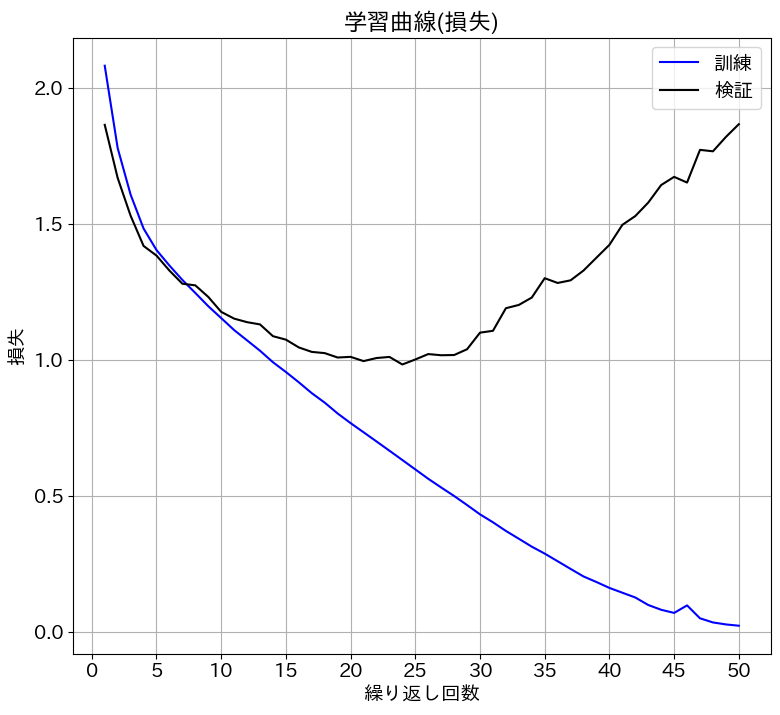

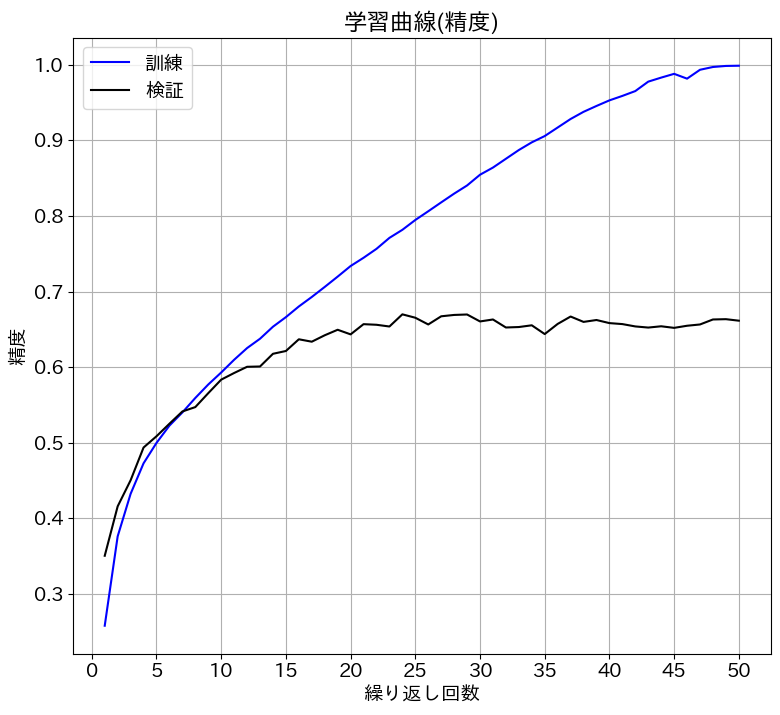

In [22]:
# 評価
evaluate_history(history2)

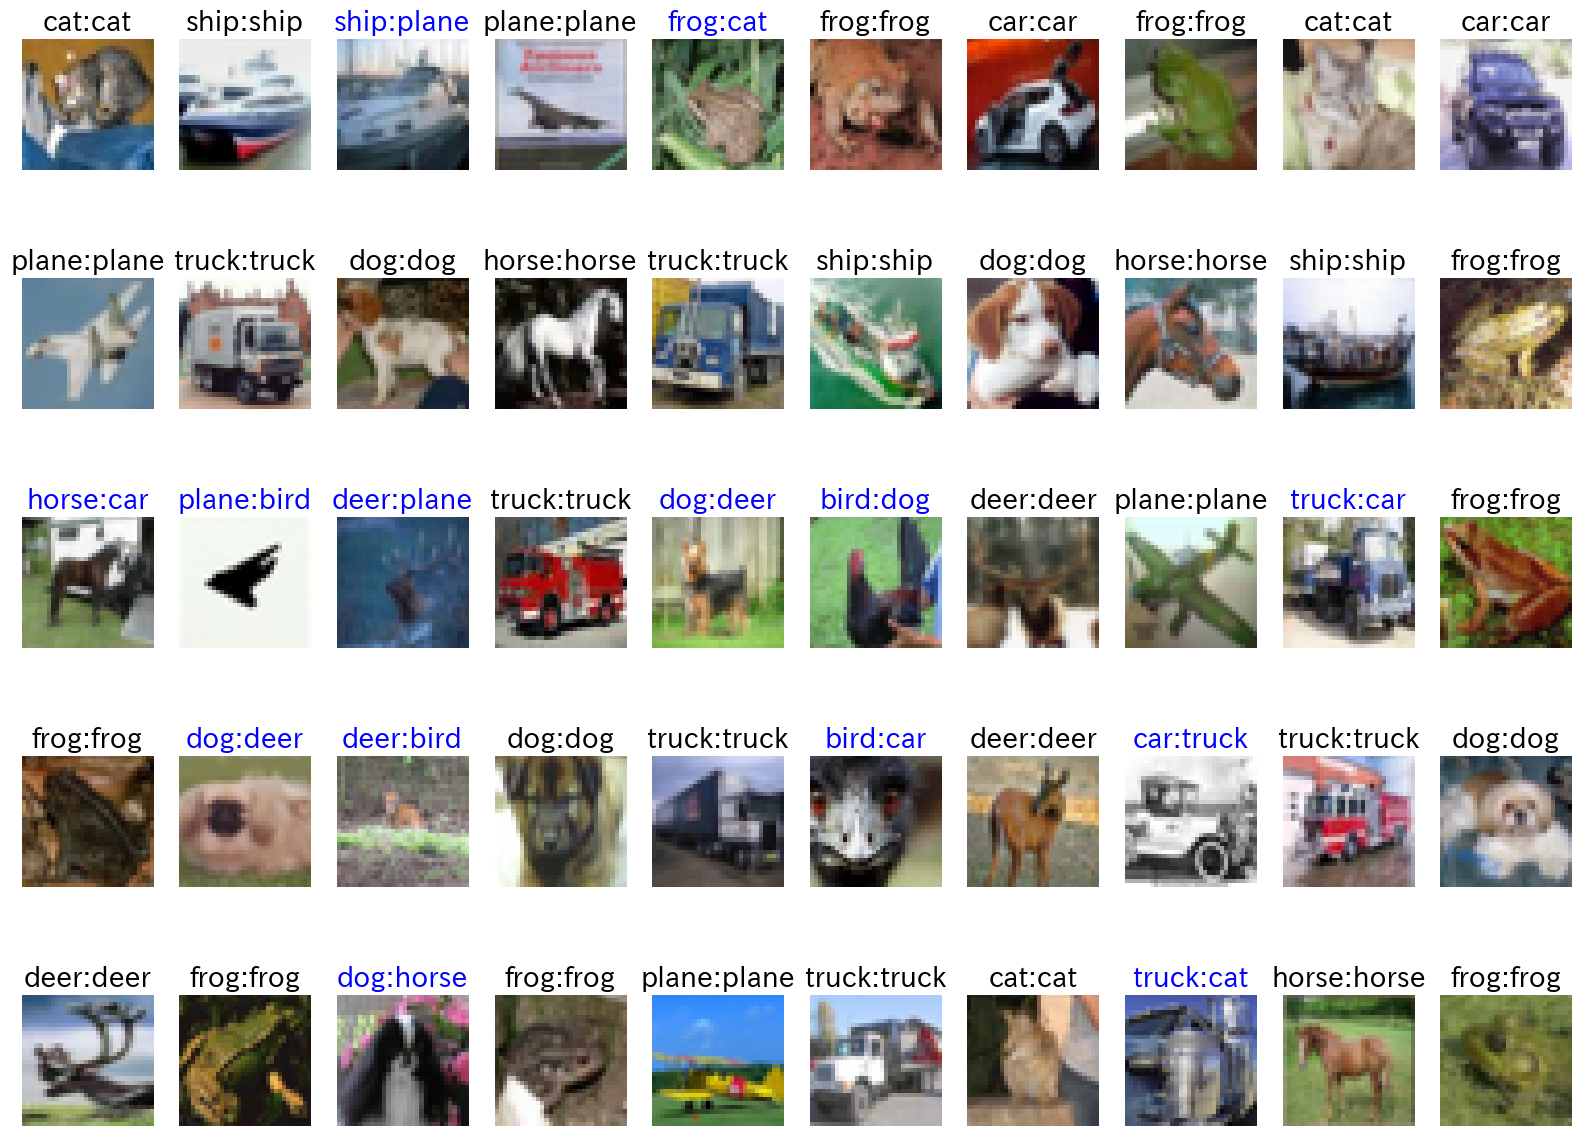

In [23]:
# 最初の50個の表示
show_images_labels(test_loader2, classes, net, device)

- 過学習気味、20回程度で止めておくべきだったと考えられる
- 精度は66%程度まで到達
    - 記事にはしていないが、全結合版は53%程度だったので、精度向上
- まだまだ誤認識が多い
- 次はチューニングを行う